<!-- <img src="images/dask_horizontal.svg"
     align="right"
     width="45%"
     alt="Dask logo\"> -->
     
<img src="images/dask_horizontal.svg"
     width="45%"
     alt="Dask logo\">
     
# Parallel Computing in Python with Dask

## James Bourbeau
#### Data Driven Wisconsin Conference

July 31, 2019

https://github.com/jrbourbeau/ddw-dask

## Outline

- [Overview: What is/why Dask?](#Overview)

- [High Level Collections](#High-Level-Collections)

    - [Dask Arrays](#Dask-Arrays)
    
    - [Dask DataFrames](#Dask-DataFrames)

- [Dask Delayed](#Dask-Delayed)

- [Schedulers](#Schedulers)

    - [Local Schedulers](#Local-Schedulers)

    - [Distributed Scheduler](#Distributed-Scheduler)
    
- [Scalable Machine Learning with Dask-ML](#Scalable-Machine-Learning-with-Dask-ML)

- [Additional Resources](#Additional-Resources)

# Overview

[ [Back to top](#Outline) ]

## What is Dask?

- Dask is a flexible, open source library for parallel computing in Python

    - GitHub: https://github.com/dask/dask
    
    - Documentation: https://docs.dask.org

- Scales the existing Python ecosystem

## Why Dask?

- Integrates very well with the PyData ecosystem

- Uses familiar APIs you're used to from NumPy, Pandas, and scikit-learn

- Allows you to scale existing workflows with minimal code changes

- Enables parallel and larger-than-memory computations

- Dask works on your laptop, but also scales out to large clusters

- Offers great built-in diagnosic tools

## Components of Dask

There are two main components of Dask:

- High- and low-level interfaces for creating task graphs to perform a computation

- Task schedulers to execute the task graph

<img src="images/overview.jpg" width="70%">

## Task Graphs

- Graph of inter-related tasks with dependencies between them

- Circular nodes in the graph are normal Python function calls

- Square nodes are normal Python objects that are created by one task as output and can be used as inputs in another task

In [1]:
def inc(i):
    return i + 1

def add(a, b):
    return a + b

a, b = 1, 12
c = inc(a)
d = inc(b)
f = add(c, d)

![](images/inc-add.png)

# High Level Collections

[ [Back to top](#Outline) ]

## Dask Arrays

- Dask arrays are chunked, n-dimensional arrays

- Can think of a Dask array as a collection of NumPy `ndarray` arrays

- Dask arrays implement a large subset of the NumPy API using blocked algorithms

- For many purposes Dask arrays can serve as drop-in replacements for NumPy arrays

<img src="images/dask-array-black-text.svg">

In [2]:
import numpy as np
import dask.array as da

In [3]:
a_np = np.arange(1, 50, 3)
a_np

array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49])

Specify a `chunks` argument to tell Dask how to break up the underlying array into chunks.

In [4]:
a_da = da.arange(1, 50, 3, chunks=5)

In [5]:
type(a_da)

dask.array.core.Array

In [6]:
a_da.chunks

((5, 5, 5, 2),)

In [7]:
a_da    # Dask arrays have nice HTML output in Jupyter notebooks

dask.array<arange, shape=(17,), dtype=int64, chunksize=(5,)>

Dask arrays look and feel like NumPy arrays. For example, they have `dtype` and `shape` attributes

In [8]:
print(a_da.dtype)
print(a_da.shape)

int64
(17,)


Dask arrays are _lazily_ evaluated. The result from a computation isn't computed until you ask for it. Instead, a Dask task graph for the computation is produced. You can visualize the task graph using the `visualize()` method.

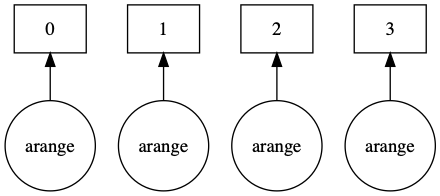

In [9]:
a_da.visualize()

To compute a task graph call the `compute()` method

In [10]:
a_da.compute()    # We'll go into more detail about .compute() later on

array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49])

The result of this computation is a fimilar NumPy `ndarray`

In [11]:
type(a_da.compute())

numpy.ndarray

Dask arrays support a large portion of the NumPy interface:

- Arithmetic and scalar mathematics: `+`, `*`, `exp`, `log`, ...

- Reductions along axes: `sum()`, `mean()`, `std()`, `sum(axis=0)`, ...

- Tensor contractions / dot products / matrix multiply: `tensordot`

- Axis reordering / transpose: `transpose`

- Slicing: `x[:100, 500:100:-2]`

- Fancy indexing along single axes with lists or numpy arrays: `x[:, [10, 1, 5]]`

- Array protocols like `__array__` and `__array_ufunc__`

- Some linear algebra: `svd`, `qr`, `solve`, `solve_triangular`, `lstsq`, ...

- ...

See the [Dask array API docs](http://docs.dask.org/en/latest/array-api.html) for full details about what portion of the NumPy API is implemented for Dask arrays.

### Blocked Algorithms

Dask arrays are implemented using _blocked algorithms_. These algorithms break up a computation on a large array into many computations on smaller peices of the array. This minimizes the memory load (amount of RAM) of computations and allows for working with larger-than-memory datasets in parallel.

In [12]:
x = da.random.random(20, chunks=5)
x

dask.array<random_sample, shape=(20,), dtype=float64, chunksize=(5,)>

In [13]:
result = x.sum()
result

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=()>

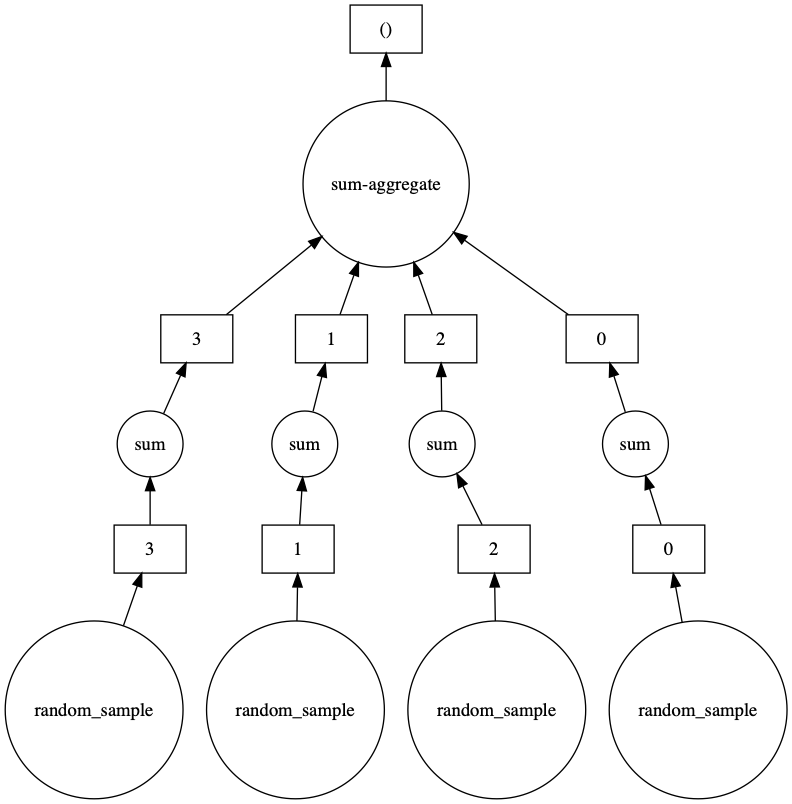

In [14]:
result.visualize()

In [15]:
result.compute()

10.352526852331883

Dask supports a large portion of the NumPy API. This can be used to build up more complex computations using the familiar NumPy operations you're used to.

In [16]:
x = da.random.random(size=(15, 15), chunks=(10, 5))
x

dask.array<random_sample, shape=(15, 15), dtype=float64, chunksize=(10, 5)>

In [17]:
result = (x + x.T).sum()
result

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=()>

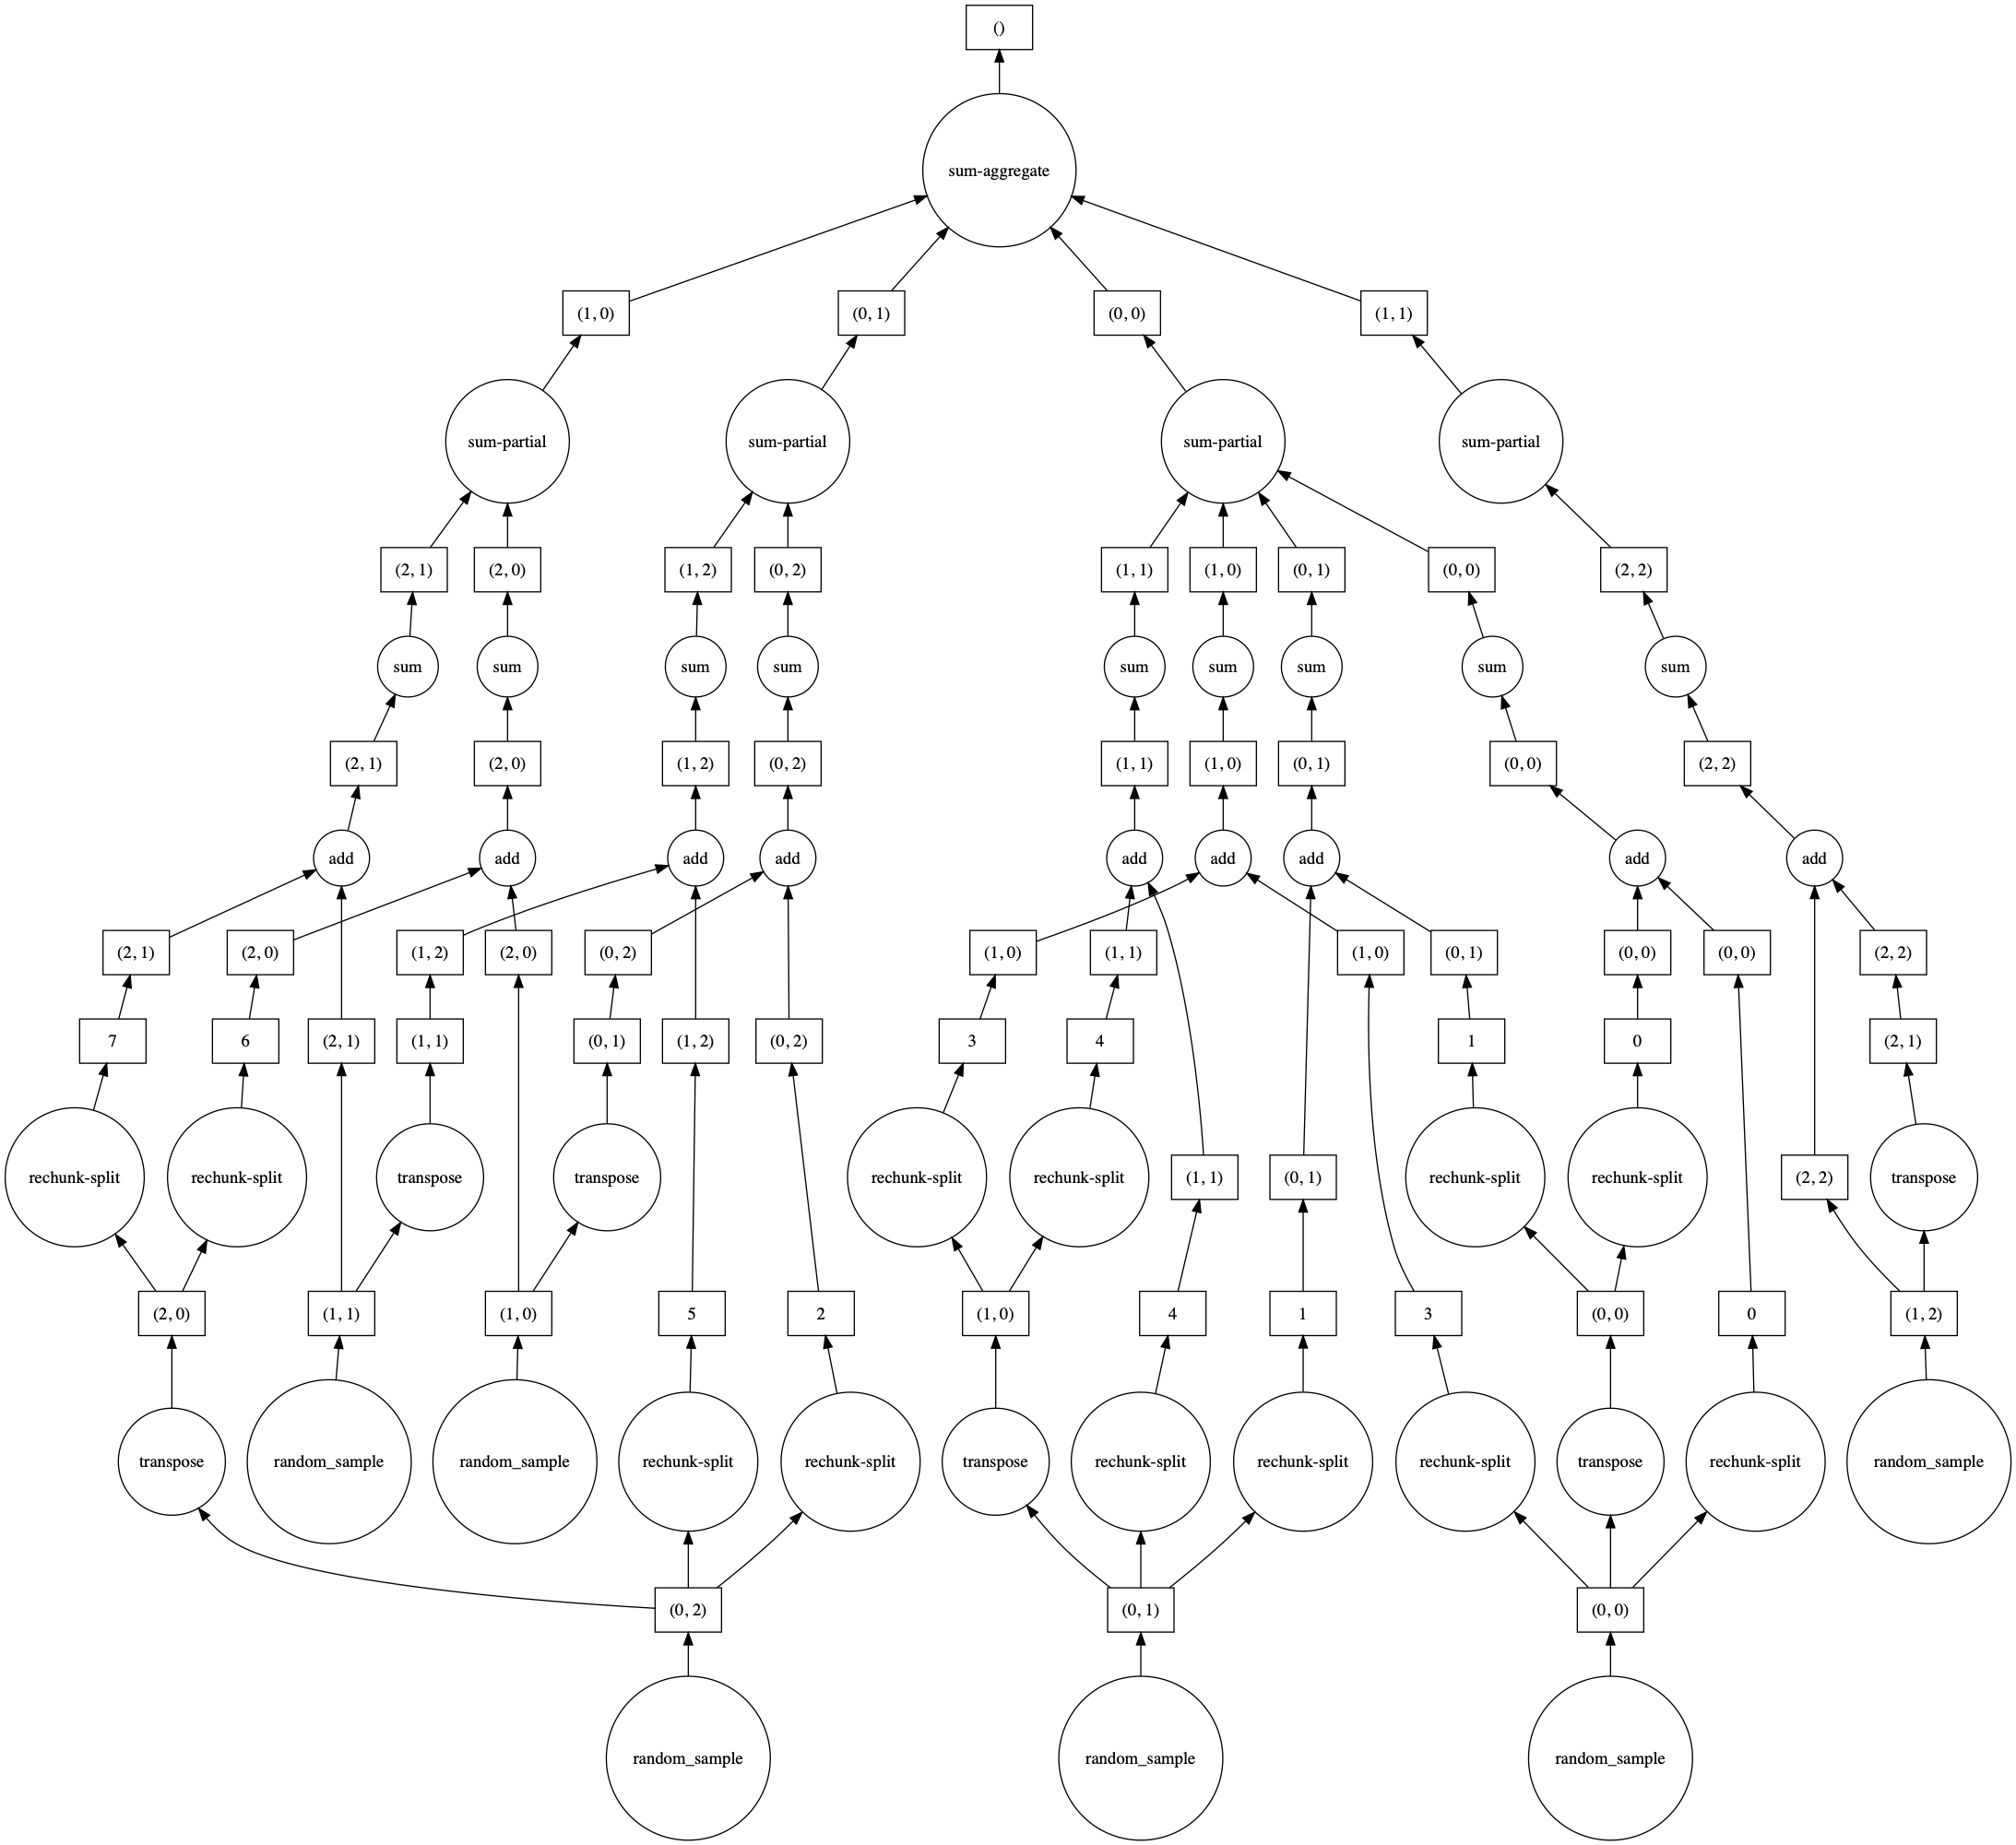

In [18]:
result.visualize()

In [19]:
result.compute()

224.85222523059434

We can perform computations on larger-than-memory arrays!

In [20]:
x = da.random.random(size=(40_000, 40_000), chunks=(2_000, 2_000))

In [21]:
x.nbytes / 1e9    # Size of array in gigabytes

12.8

In [22]:
result = (x + x.T).sum()

In [23]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    result.compute()

[########################################] | 100% Completed | 16.5s


**Note**: that Dask can be used to scale other array-like libraries that support the NumPy `ndarray` interface. For example, [pydata/sparse](https://sparse.pydata.org/en/latest/) for sparse arrays or [CuPy](https://cupy.chainer.org/) for GPU-accelerated arrays.

## Dask DataFrames

[Pandas](http://pandas.pydata.org/pandas-docs/stable/) is great for dealing with tabular datasets that can fit in memory. Dask becomes useful when dealing with larger-than-memory datasets. We saw that a Dask arrays are composed of many NumPy arrays, chunked along one or more dimensions. It's similar for Dask DataFrames: a Dask DataFrame is composed of many Pandas DataFrames and the partitioning happens only along the index.

- Dask DataFrames are a collection of Pandas DataFrames

- Dask DataFrames implement a subset of the Pandas API

- Backed by blocked algorithms that allow for parallel and out of core computation

- For many purposes Dask DataFrames can serve as drop-in replacements for Pandas DataFrames

<img src="images/dask-dataframe.svg" width="400px">

In [24]:
import pandas as pd
import dask.dataframe as dd

Dask DataFrames support many of the same data I/O methods as Pandas. For example, 

- `read_csv` \ `to_csv`
- `read_hdf` \ `to_hdf`
- `read_json` \ `to_json`
- `read_parquet` \ `to_parquet`

Can specify a `chunksize` argument to set the number of rows per partition

In [25]:
ddf = dd.read_hdf('example_data.hdf', key='dataframe', chunksize=25)
ddf

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
npartitions=4,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


The `npartitions` attribute tells us how many Pandas DataFrames make up our Dask DataFrame

In [26]:
ddf.npartitions

4

Like Dask arrays, Dask DataFrames are lazily evaluated. Here, the `dd.read_hdf` function wraps several calls to `pd.read_hdf`, once for each partition of the Dask DataFrame.

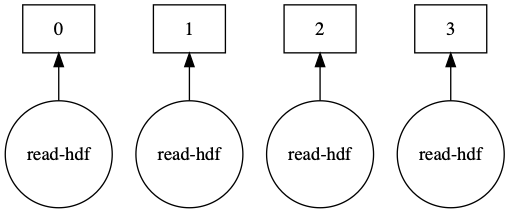

In [27]:
ddf.visualize()

Dask DataFrames cover a well-used portion of the Pandas API:

- Elementwise operations: `df.x` + `df.y`, `df * df`

- Row-wise selections: `df[df.x > 0]`

- Loc: `df.loc[4.0:10.5]`

- Common aggregations: `df.x.max()`, `df.max()`

- Is in: `df[df.x.isin([1, 2, 3])]`

- Datetime/string accessors: `df.timestamp.month`

- Froupby-aggregate (with common aggregations): `df.groupby(df.x).y.max()`, `df.groupby('x').max()`

- ...

See the [Dask DataFrame API docs](http://docs.dask.org/en/latest/dataframe-api.html) for full details about what portion of the Pandas API is implemented for Dask DataFrames.

In [28]:
col_sum = ddf['col_1'].sum()
col_sum

dd.Scalar<series-..., dtype=float64>

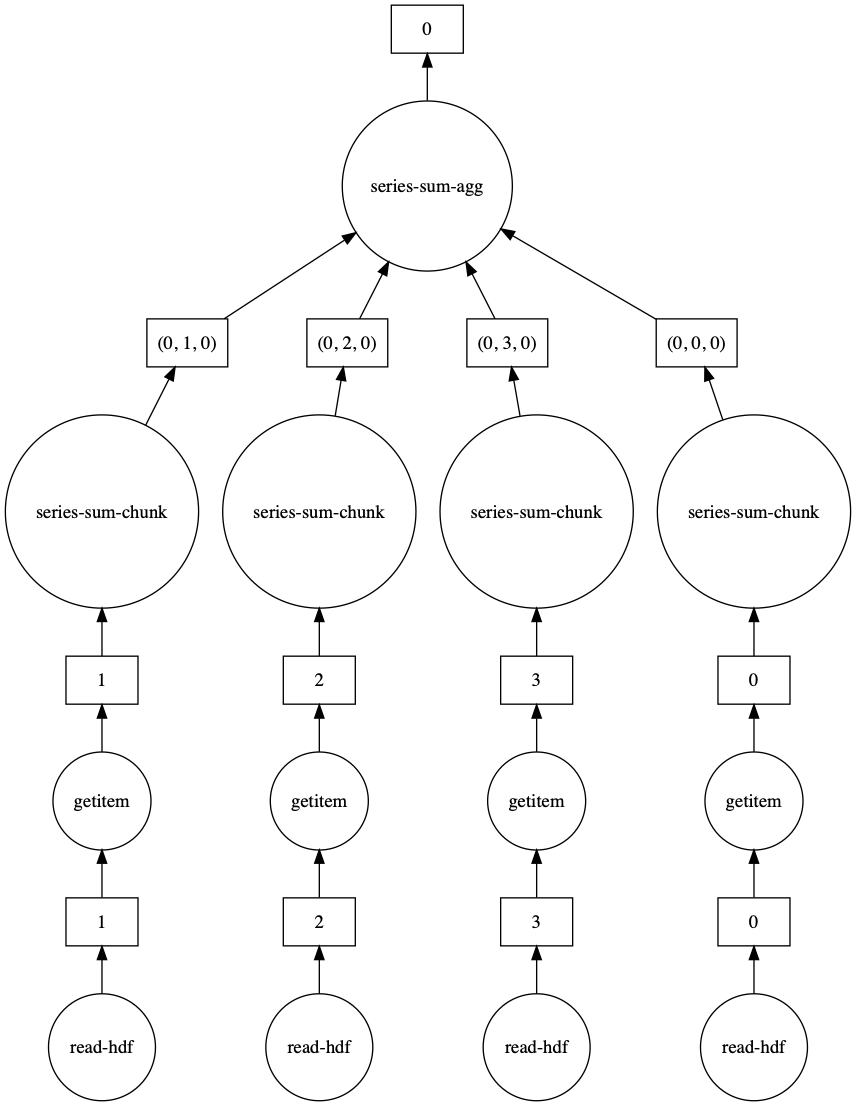

In [29]:
col_sum.visualize()

In [30]:
col_sum.compute()

47.437545006447664

# Dask Delayed

[ [Back to top](#Outline) ]

Sometimes problems don’t fit nicely into one of the high-level collections like Dask arrays or Dask DataFrames. In these cases, you can parallelize custom algorithms using the lower-level Dask `delayed` interface. This allows one to manually create task graphs with a light annotation of normal Python code.

In [31]:
import time

In [32]:
def inc(x):
    time.sleep(0.5)
    return x + 1

def double(x):
    time.sleep(0.5)
    return 2 * x

def add(x, y):
    time.sleep(0.5)
    return x + y

In [33]:
%%time

data = [1, 2, 3, 4]

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = sum(output)

CPU times: user 7.51 ms, sys: 3.68 ms, total: 11.2 ms
Wall time: 6.03 s


Dask `delayed` wraps function calls and delays their execution. Rather than computing a results immediately, `delayed` functions record what we want to compute as a task into a graph that we’ll run later on parallel hardware by calling `compute`.

In [34]:
from dask import delayed

In [35]:
lazy_inc = delayed(inc)

In [36]:
%time inc_output = lazy_inc(3)  # lazily evaluate inc(3)

CPU times: user 307 µs, sys: 299 µs, total: 606 µs
Wall time: 371 µs


In [37]:
inc_output

Delayed('inc-3fed04a6-d664-4b40-be23-347e5efaa6f3')

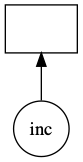

In [38]:
inc_output.visualize()

In [39]:
inc_output.compute()

4

Using delayed functions, we can build up a task graph for the particular computation we want to perform

In [40]:
double_inc_output = lazy_inc(inc_output)
double_inc_output

Delayed('inc-17dcbd67-bde6-4464-84dd-62577e6ccc1d')

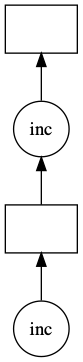

In [41]:
double_inc_output.visualize()

In [42]:
double_inc_output.compute()

5

We can use `delayed` to make our previous example computation lazy by wrapping all the function calls with delayed

In [43]:
@delayed
def inc(x):
    time.sleep(0.5)
    return x + 1

@delayed
def double(x):
    time.sleep(0.5)
    return 2 * x

@delayed
def add(x, y):
    time.sleep(0.5)
    return x + y

Now `add` returns a `Delayed` object which you can call `compute()` on at a later time

In [44]:
%%time

data = [1, 2, 3, 4]

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = delayed(sum)(output)
total

CPU times: user 1.87 ms, sys: 547 µs, total: 2.42 ms
Wall time: 3.6 ms


Delayed('sum-a9a0f0ee-6b9d-4e27-b2c5-1e1313849ddd')

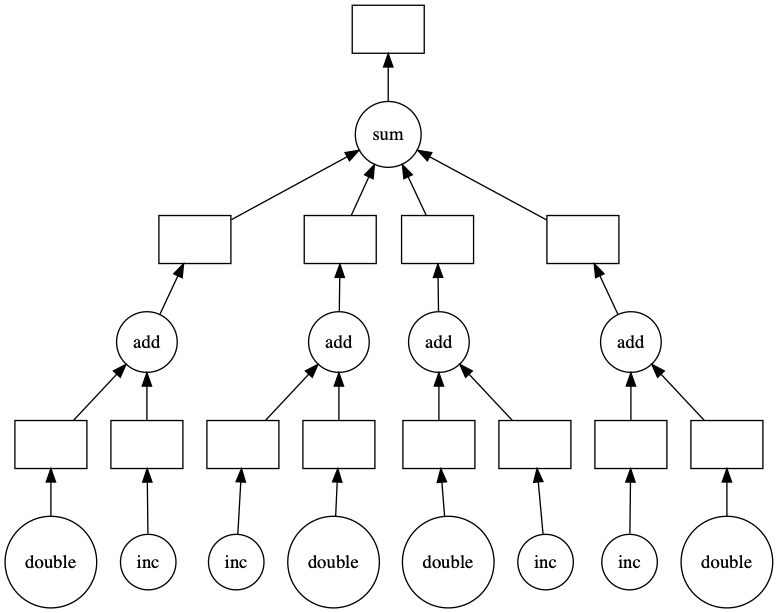

In [45]:
total.visualize()

In [46]:
%%time

total.compute()

CPU times: user 5.82 ms, sys: 3.57 ms, total: 9.39 ms
Wall time: 2.01 s


34

I highly recommend checking out the [Dask delayed best practices](http://docs.dask.org/en/latest/delayed-best-practices.html) page to avoid some common problems when using `delayed`. 

# Schedulers

[ [Back to top](#Outline) ]

High-level collections like Dask arrays and Dask DataFrames, as well as the low-level `dask.delayed` interface build up task graphs for a computation. After these graphs are generated, they need to be executed (potentially in parallel). This is the job of a task scheduler. Different task schedulers exist within Dask. Each will consume a task graph and compute the same result, but with different performance characteristics. 

![grid-search](images/grid_search_schedule.gif "grid-search")

Dask has two different classes of schedulers: local schedulers and the distributed scheduler.

## Local Schedulers

[ [Back to top](#Outline) ]

Local schedulers provide basic features on a local process or thread pool and require no setup (only use Python standard library). The different local schedulers Dask provides are:

- `'threads'`: The threaded scheduler executes computations with a local `multiprocessing.pool.ThreadPool`. The threaded scheduler is the default choice for Dask arrays, Dask DataFrames, and Dask delayed. 

- `'processes'`: The multiprocessing scheduler executes computations with a local `multiprocessing.Pool`.

- `'single-threaded'`: The single-threaded synchronous scheduler executes all computations in the local thread, with no parallelism at all. This is particularly valuable for debugging and profiling, which are more difficult when using threads or processes.

You can configure which scheduler is used in a few different ways. You can set the scheduler globablly by using the `dask.config.set(scheduler=)` command

In [47]:
import dask

dask.config.set(scheduler='threads')
total.compute(); # Will use the multi-threading scheduler

or use it as a context manager to set the scheduler for a block of code

In [48]:
with dask.config.set(scheduler='processes'):
    total.compute()  # Will use the multi-processing scheduler

or even within a single compute call

In [49]:
total.compute(scheduler='threads');  # Will use the multi-threading scheduler

The `num_workers` argument is used to specify the number of threads or processes to use

In [50]:
total.compute(scheduler='threads', num_workers=4);

## Distributed Scheduler

[ [Back to top](#Outline) ]

Despite having "distributed" in it's name, the distributed scheduler works well on both single and multiple machines. Think of it as the "advanced scheduler". The Dask distributed system is composed of a single centralized scheduler and one or more worker processes. Deploying a remote Dask cluster involves some [additional setup](https://distributed.dask.org/en/latest/setup.html). But doing things locally is just involves creating a `Client` object, which lets you interact with the "cluster" (local threads or processes on your machine).

In [51]:
from dask.distributed import Client

In [52]:
client = Client(processes=False,
                n_workers=1,
                threads_per_worker=3,
                memory_limit='1GB')
client

Client Scheduler: inproc://192.168.0.103/31579/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 3 Memory: 1000.00 MB


When we create a `Client`, by default it registers itself as the default Dask scheduler. All `.compute()` calls will automatically start using the distributed scheduler unless otherwise told to use a different scheduler. 

The distributed scheduler has many features:

- Sophisticated memory management

- Data locality

- Adaptive deployments

- Maintaining state

- ...

See the [Dask distributed documentation](https://distributed.dask.org) for full details about all the distributed scheduler features.

For this talk, I'd like to highlight two of the distributed scheduler features: real time diagnostics and the `concurrent.futures` interface.

In [53]:
x = da.ones((40_000, 40_000), chunks=(800, 800))
result = (x + x.T).sum()

In [54]:
result.compute()

3200000000.0

**Note:** When things go wrong, or when you want to reset the cluster state, you can use the `client.restart()` method.

### `concurrent.futures` interface

The Dask distributed scheduler implements a superset of Python's [`concurrent.futures`](https://docs.python.org/3/library/concurrent.futures.html) interface that allows for finer control and asynchronous computation.

The `submit` function sends a function and arguments to the distributed scheduler for processing. They return `Future` objects that refer to remote data on the cluster. The `Future` returns immediately while the computations run remotely in the background. There is no blocking of the local Python session.

In [55]:
import random

In [56]:
def inc(x):
    time.sleep(random.uniform(0, 3))
    return x + 1

In [57]:
f = client.submit(inc, 7.2)  # Submits inc(7.2) to the distributed scheduler
print(f)

<Future: status: pending, key: inc-ff5d6af5d9bf791c8057c82a7b29ad65>


Once the computation for the `Future` is complete, you can retrieve the result using the `.result()` method

In [58]:
print(f)

<Future: status: pending, key: inc-ff5d6af5d9bf791c8057c82a7b29ad65>


In [59]:
f.result()

8.2

The `map` function can be used to apply a function on a sequence of arguments (similar to the built-in Python `map` function).

In [60]:
data = range(10)
futures = client.map(inc, data)
futures

[<Future: status: pending, key: inc-92c2c5ae7a48a3a466c416abc373c5f4>,
 <Future: status: pending, key: inc-dc5bc4abc991bdb709a62bb395e12fa4>,
 <Future: status: pending, key: inc-deb877bcd8155d0ea0cc16325971ca70>,
 <Future: status: pending, key: inc-9e6c540d8d3e03c2714cc0144961c40a>,
 <Future: status: pending, key: inc-4c0c69dfa635cc2f33da3164f2422bea>,
 <Future: status: pending, key: inc-aa01fd2019f30bfadf1f516986b6f96f>,
 <Future: status: pending, key: inc-aab3a256f5d6038edd9ac6812d039cd8>,
 <Future: status: pending, key: inc-decbfcd534226a8d1b3eb9187d5ae7ee>,
 <Future: status: pending, key: inc-c2cae44fb4ad8000a7f7f44da6e76831>,
 <Future: status: pending, key: inc-9eeda934eba9909d565a371867a9faa1>]

Here a list of `Futures` are returned, one for each item in the sequence of arguments. 

In [61]:
futures

[<Future: status: pending, key: inc-92c2c5ae7a48a3a466c416abc373c5f4>,
 <Future: status: pending, key: inc-dc5bc4abc991bdb709a62bb395e12fa4>,
 <Future: status: pending, key: inc-deb877bcd8155d0ea0cc16325971ca70>,
 <Future: status: pending, key: inc-9e6c540d8d3e03c2714cc0144961c40a>,
 <Future: status: pending, key: inc-4c0c69dfa635cc2f33da3164f2422bea>,
 <Future: status: pending, key: inc-aa01fd2019f30bfadf1f516986b6f96f>,
 <Future: status: pending, key: inc-aab3a256f5d6038edd9ac6812d039cd8>,
 <Future: status: pending, key: inc-decbfcd534226a8d1b3eb9187d5ae7ee>,
 <Future: status: pending, key: inc-c2cae44fb4ad8000a7f7f44da6e76831>,
 <Future: status: pending, key: inc-9eeda934eba9909d565a371867a9faa1>]

In [62]:
results = client.gather(futures)
# Same as results = [future.result() for future in futures]

In [63]:
results

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

To delete `Futures` in distributed memory, use the `del` keyword

In [64]:
del f, futures[:]

The `concurrent.futures` API even allows you to submit tasks based on the output of other tasks. This gives more flexibility in situations where the computations may evolve over time.

In [65]:
from dask.distributed import as_completed

data = range(100)
data_iter = iter(data)
max_len = 10
futures = [client.submit(inc, next(data_iter)) for i in range(max_len)]

seq = as_completed(futures)
for future in seq:
    y = future.result()
    print(f'y = {y}')
    if y % 2 == 0:
        try:
            new_future = client.submit(inc, next(data_iter))
            seq.add(new_future)  # add back into the as_completed queue
        except StopIteration:
            pass

y = 1
y = 10
y = 2
y = 9
y = 7
y = 6
y = 5
y = 8
y = 12
y = 3
y = 11
y = 13
y = 4
y = 16
y = 15
y = 14
y = 18
y = 19
y = 17


This was a brief demo of the distributed scheduler. It's a super powerful tool and has lots of features. For more information, check out the [Distributed documentation](https://distributed.dask.org). 

# Scalable Machine Learning with Dask-ML

[ [Back to top](#Outline) ]

[Dask-ML](http://ml.dask.org/) is a Python library for scalable machine learning in Python. Build on top of Dask collections and supports the scikit-learn API. 

Three different approaches are taken to scaling modern machine learning algorithms:

- Parallelize scikit-learn directly

- Reimplement scalable algorithms with Dask arrays

- Partner with other distributed libraries (like XGBoost and TensorFlow)

In [66]:
from dask_ml.datasets import make_classification
from dask_ml.model_selection import train_test_split
from dask_ml.metrics import accuracy_score
from dask_ml.linear_model import LogisticRegression

In [67]:
X, y = make_classification(n_samples=1000,
                           n_features=2,
                           n_classes=2,
                           random_state=2,
                           chunks=10)

In [68]:
X

,Array,Chunk
Bytes,16.00 kB,160 B
Shape,"(1000, 2)","(10, 2)"
Count,100 Tasks,100 Chunks
Type,float64,numpy.ndarray


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=2)

In [70]:
clf = LogisticRegression(max_iter=2)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1.0, max_iter=2, multi_class='ovr',
                   n_jobs=1, penalty='l2', random_state=None, solver='admm',
                   solver_kwargs=None, tol=0.0001, verbose=0, warm_start=False)

In [71]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6766666666666666

# Additional Resources

[ [Back to top](#Outline) ]

- Dask links:

    - GitHub repository: https://github.com/dask/dask

    - Documentation: https://docs.dask.org

    - Dask examples repository: https://github.com/dask/dask-examples

- There are lots of great Dask tutorial from various conference on YouTube. For example:

    - "Parallelizing Scientific Python with Dask" @ SciPy 2018: [YouTube](https://www.youtube.com/watch?v=mqdglv9GnM8)
    
    - "Scalable Machine Learning with Dask" @ SciPy 2018: [YouTube](https://www.youtube.com/watch?v=ccfsbuqsjgI)

- If you have a Dask usage questions, please ask it on [Stack Overflow with the #dask tag](https://stackoverflow.com/questions/tagged/dask). Dask developers monitor this tag and will answer questions.

- If you run into a bug, feel free to file a report on the [Dask GitHub issue tracker](https://github.com/dask/dask/issues).